Import important libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from PIL import Image
from random import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

Class for dumping and loading pickle files of exceedingly large sizes

Reads data byte by byte and writes data byte by byte

In [2]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

Loading training image data

In [3]:
train_data = pickle_load('./data/train_image.pkl')

Loading training labels

In [4]:
train_label = pickle_load('./data/train_label.pkl')

# Analyse training dataset

In [5]:
print(type(train_data))
print(len(train_data))
print(type(train_data[0]))
print(len(train_data[0]))

<class 'list'>
8000
<class 'list'>
784


In [6]:
print(type(train_label))
print(len(train_label))

<class 'list'>
8000


In [7]:
st = set()
ct0 = 0
ct2 = 0
ct3 = 0
ct6 = 0
for x in train_label:
    st.add(x)
    if x == 0:
        ct0 += 1
    if x == 2:
        ct2 += 1
    if x == 3:
        ct3 += 1
    if x == 6:
        ct6 += 1
print(st)
print("label 0: ", ct0)
print("label 2: ", ct2)
print("label 3: ", ct3)
print("label 6: ", ct6)

{0, 2, 3, 6}
label 0:  2000
label 2:  2000
label 3:  2000
label 6:  2000


Training dataset has 8000 lists of size=784. A rough assumption is that these might be images which have been flattened. But we may be wrong!! For this, we have to get the factors of 784(which might be the dimensions of the image).

1 × 784 = 784

2 × 392 = 784

4 × 196 = 784

7 × 112 = 784

8 × 98 = 784

14 × 56 = 784

16 × 49 = 784

28 × 28 = 784

Lets try 28 x 28 images first.

In [8]:
image_test = train_data[2314] #Any random image chosen(not important)

In [9]:
image_test = np.array(image_test)

In [10]:
image_test = np.reshape(image_test , (28,28))

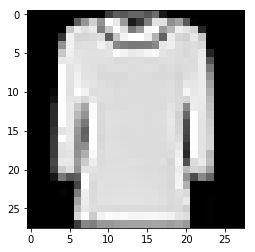

In [11]:
plt.imshow(image_test, cmap="gray")
plt.show()

Hola!! It seems we were right all along. These are actually images of size 28 x 28 pixels. We plot some more images and get the idea that these are images of clothes. Especially upper body clothes. Using our previous knowledge in the field of Deep Learning and Computer Vision, we come to the conclusion that this dataset is a subset of the FashionMNIST dataset. 

However, since we are not allowed to augment the dataset using external sources, we wont be doing that at all. However, this dataset has only 2000 images for 4 classes. We will have to augment it as the original dataset contained around 6000 images for 10 classes. 

# Data Augmentation

Shuffle the dataset properly

In [12]:
temp_for_shuffle = []
for i in range(len(train_data)):
    tup = (train_data[i], train_label[i])
    temp_for_shuffle.append(tup)

In [13]:
shuffle(temp_for_shuffle)
shuffle(temp_for_shuffle)

Append the shuffled dataset into numpy arrays of X and y

In [14]:
X = []
y = []
for i in range(len(temp_for_shuffle)):
    y.append(temp_for_shuffle[i][1])
    X.append(np.reshape(np.array(temp_for_shuffle[i][0]), (28,28)))

In [15]:
y = np.array(y)
X = np.array(X)

In [16]:
y.shape

(8000,)

In [17]:
X.shape

(8000, 28, 28)

Since X contains grayscale images, we need to scale them between 0 and 1 before feeding them into any deep learning model.

In [18]:
X = X / 255

Every deep learning model requires that the variable to be predicted should be one hot encoded. For that to be there, we need to change the labels from 0,2,3,6 to be 0,1,2,3. For this, we maintain a small dictionary and pickle it along with the augmented dataset as well.

In [19]:
dict = {
    0:0,
    1:2,
    2:3,
    3:6
}

In [20]:
y_new = []
for x in y:
    if x == 0:
        y_new.append(0)
    if x == 2:
        y_new.append(1)
    if x == 3:
        y_new.append(2)
    if x == 6:
        y_new.append(3)
y = np.array(y_new)
print("Updated labels in the form of [0,1,2,3]: ", y)

Updated labels in the form of [0,1,2,3]:  [1 1 2 ... 3 1 0]


One hot encode the labels

In [21]:
n_values = np.max(y) + 1
y_new = np.eye(n_values)[y]
y = y_new

In [22]:
print(y[2314]) #Any random number(doesn't matter)
print(y.shape)

[0. 0. 0. 1.]
(8000, 4)


## Augmenting the dataset using rotation and flipping

In [23]:
"""
Pick a random degree of rotation between 25% on the left and 25% on the right
"""
def random_rotation(image_array: ndarray):
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

"""
Vertical flipping is as easy as flipping the image array of pixels !
"""
def vertical_flip(image_array: ndarray):
    return image_array[::-1, :]

#dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'vertical_flip': vertical_flip
}

Augmenting the dataset using flipping and rotation and then appending duplicate labels according to the generated images.

In [24]:
X_new = []
y_new = []
for i in range(X.shape[0]):
    image_to_transform = X[i]

    rotated = available_transformations['rotate'](image_to_transform)
    vertical_flipped = available_transformations['vertical_flip'](image_to_transform)
    #rot_and_flipped = available_transformations['vertical_flip'](rotated)
    
    X_new.append(rotated)
    X_new.append(vertical_flipped)
    X_new.append(image_to_transform)
    
    y_new.append(y[i])
    y_new.append(y[i])
    y_new.append(y[i])

In [25]:
X_new = np.array(X_new)
y_new = np.array(y_new)

In [26]:
X = X_new
y = y_new
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (24000, 28, 28)
y shape:  (24000, 4)


Rehsaping X because Convolutional layers take as input 4D arrays

In [27]:
X = np.reshape(X , (24000,28,28,1))

In [28]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (24000, 28, 28, 1)
y shape:  (24000, 4)


# Splitting into training and validation sets

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [30]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (16800, 28, 28, 1)
y_train shape:  (16800, 4)
X_val shape:  (7200, 28, 28, 1)
y_val shape:  (7200, 4)


# Dumping the augmented dataset in a pickle file

In [31]:
dataset = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'dict': dict
}
pickle_dump(dataset, './data/dataset_large.pkl')

writing total_bytes=151296376...
writing bytes [0, 151296376)... done.
